In [1]:
# Data-handling libraries
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Network libraries
import networkx as nx
import netwulf as nw

# Import utils
from network_utils import *

In [2]:
# Load formatted book (dict of chapters with list of lists of pages and sentences)
with open("1.Dataset_files/Books_formatted/Book1.pkl","rb") as f:
    book = pkl.load(f)

print(f" Number of chapters: {len(book)}, number of pages: {sum([len(chapter) for chapter in book.values()])}, number of sentences: {sum([sum([len(page) for page in chapter]) for chapter in book.values()])}")

# Load characters wiki
character_df = pd.read_csv("1.Dataset_files/CharacterWikis_clean.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]
character_df.Tokens = [eval(t) for t in character_df.Tokens]

# dict so we have all nodes (list of dicts of all character names (str) and their aliases (list of str)))
characters = []
for i, char in enumerate(character_df.Aliases):

    characters.append({'name':character_df['Name'].iloc[i], 'aliases': char + [character_df['Name'].iloc[i]]})

print(f" Number of characters: {len(characters)}, number of aliases: {sum([len(char['aliases']) for char in characters])}")

 Number of chapters: 17, number of pages: 347, number of sentences: 4929
 Number of characters: 677, number of aliases: 2000


In [3]:
# Draw network
G = nx.Graph()

# Add nodes to graph
for character in tqdm(characters, desc='Adding character nodes to graph...'):
    character['sizes'] = get_node_size(character['aliases'], book)
    G.add_node(character['name'], sizes=character['sizes'], attr=character['aliases'])

# Add edges to graph
for i, char1 in enumerate(tqdm(characters, desc='Adding edges to graph...')):
    for j, char2 in enumerate(characters[i+1:]):
        edge_weight = get_edge_book_weight(char1['aliases'], char2['aliases'], book)
        if sum(edge_weight.values()) != 0:
            G.add_edge(char1['name'], char2['name'], weight=edge_weight)

Adding edges to graph...: 100%|██████████| 677/677 [11:52<00:00,  1.05s/it] 


In [4]:
Gs = [nx.Graph()]
tempbook = {}

for chapternr in range(1,4):
    tempG = nx.Graph()
    tempbook[chapternr] = book[chapternr]
    for character in tqdm(characters, desc='Adding character nodes to graph...'):
        character['sizes'] = get_node_size(character['aliases'], tempbook)
        tempG.add_node(character['name'], sizes=character['sizes'], attr=character['aliases'])

    # Add edges to graph
    for i, char1 in enumerate(tqdm(characters, desc='Adding edges to graph...')):
        for j, char2 in enumerate(characters[i+1:]):
            edge_weight = get_edge_book_weight(char1['aliases'], char2['aliases'], tempbook)
            if sum(edge_weight.values()) != 0:
                tempG.add_edge(char1['name'], char2['name'], weight=edge_weight)
    Gs.append(nx.compose(Gs[-1],tempG))

Adding edges to graph...: 100%|██████████| 677/677 [01:17<00:00,  8.76it/s]


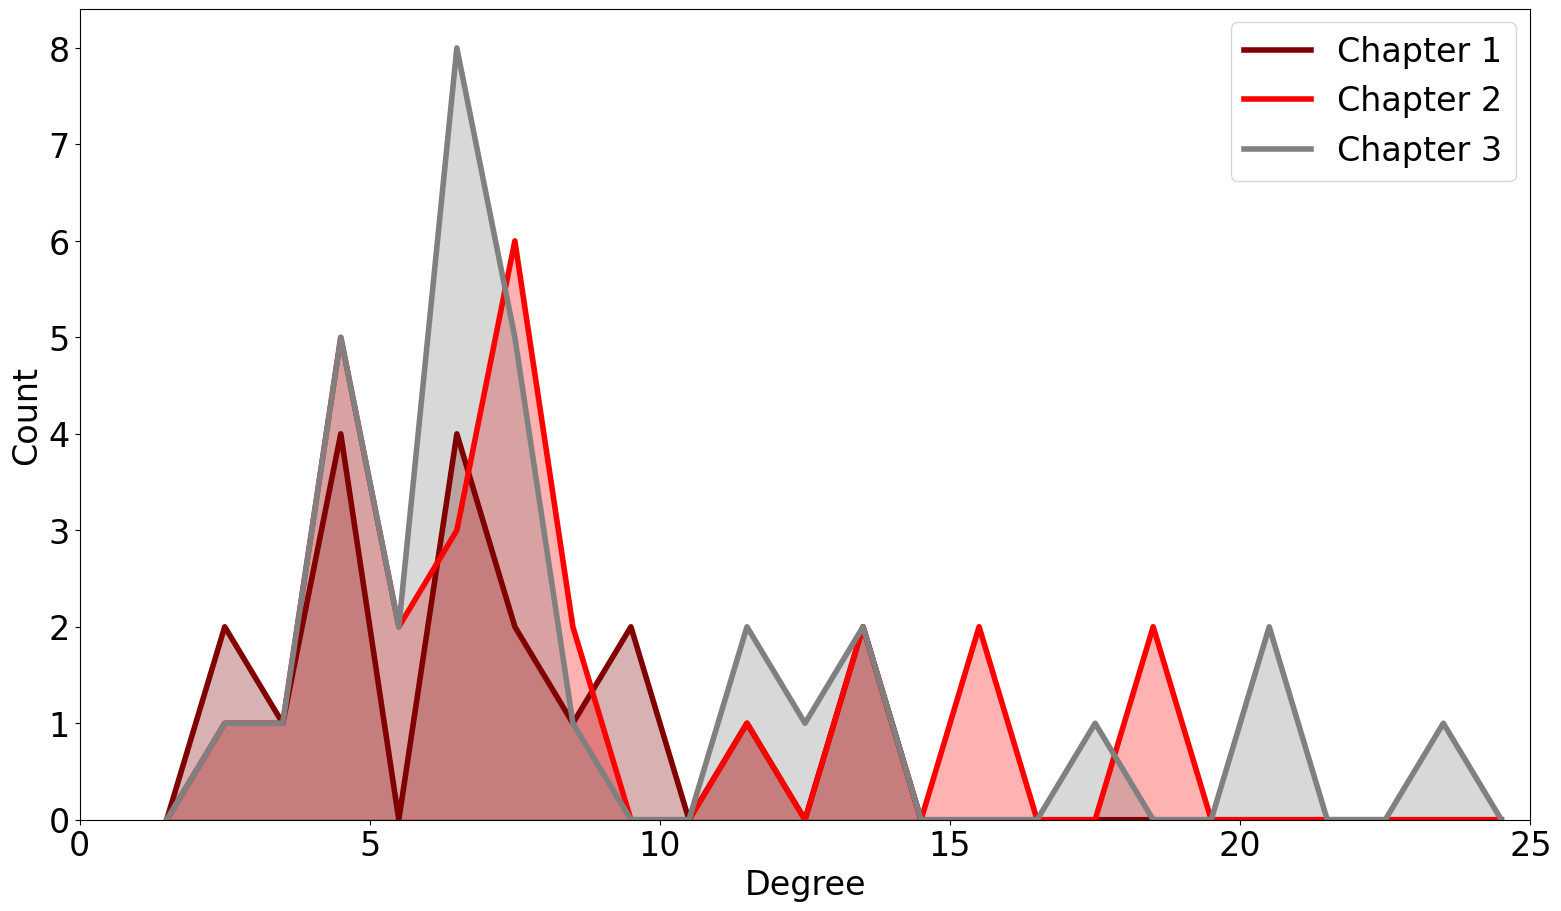

In [48]:
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(15.5, 9), constrained_layout=True)
plt.rcParams.update({'font.size': 12})

# degrees = []
for chapternr, g, color in zip(range(1,4), Gs[1:], ['maroon','red','gray']):
    degrees = [g.degree(n) for n in g.nodes if g.degree(n) != 0]

    # axs[chapternr-1].hist(degrees, range=(1,25), bins=10, width=0.8, color=color, label=f"Chapter {chapternr}")
    bins = np.linspace(1,25,25)
    hist, edges = np.histogram(degrees, bins=bins)
    x = (edges[1:]+edges[:-1])/2
    width = bins[1] - bins[0]
    plt.plot(x, hist, color=color, label=f"Chapter {chapternr}", linewidth=4)
    plt.fill_between(x, np.zeros(len(x)), hist, color=color, alpha=0.3)

fig.legend(prop={'size': 24}, ncol=1, loc='upper right', bbox_to_anchor=(0.985, 1))
plt.tick_params(axis='both', which='major', labelsize=24)
plt.xlim(0,25)
plt.gca().set_ylim(bottom=0)
plt.xlabel('Degree', fontsize=24)
plt.ylabel('Count', fontsize=24)
plt.show()


In [165]:
#Clustering coefficient
def clustering_coefficient(G):
    cc_s = []
    for node in G.nodes():
        
        Triangles = []
        
        neighbors_main = [n for n in G.neighbors(node)]
        n_neighbors = len(neighbors_main)

        for neighbor in neighbors_main:
            neighbor_neighbors = G.neighbors(neighbor)
            
            for nn in neighbor_neighbors:
                if nn in neighbors_main:
                    if (nn, neighbor) not in Triangles and (neighbor, nn) not in Triangles:
                        Triangles.append((nn, neighbor))

        if n_neighbors < 2:
            cc_s.append(0)
        else:
            possible_triangles = n_neighbors*(n_neighbors-1)/2
            cc_s.append(len(Triangles)/possible_triangles)
                
    return np.mean(cc_s)

#Average clustering coefficient
for i,g in enumerate(Gs[1:]):
    print(f"Clustering coefficient for network in chapter {i+1} is {clustering_coefficient(g)}")
    print(f"Number of edges in network in chapter {i+1} is {g.number_of_edges()} \n")


Clustering coefficient for network in chapter 1 is 0.02256115786396436
Number of edges in network in chapter 1 is 62 

Clustering coefficient for network in chapter 2 is 0.03244420739859093
Number of edges in network in chapter 2 is 107 

Clustering coefficient for network in chapter 3 is 0.03875343965811917
Number of edges in network in chapter 3 is 133 



Graph with 677 nodes and 1509 edges


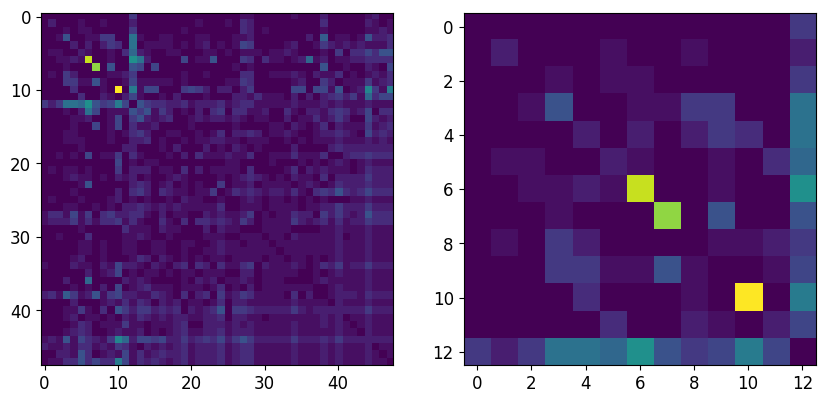

In [166]:
degree_matrix = nx.degree_mixing_matrix(G, normalized=True)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(degree_matrix)

# ax[1].x
ax[1].imshow(degree_matrix[:13,:13])


#Highlights:
print(G)

In [5]:
character_df['Name'].tolist()

['Vernon Dursley',
 'Petunia Dursley',
 'Dudley Dursley',
 'Lily Potter',
 'James Potter',
 'Harry Potter',
 'Violet-cloaked wizard',
 'Lord Voldemort',
 'Jim McGuffin',
 'Ted',
 "Vernon Dursley's secretary",
 'Albus Dumbledore',
 'Minerva McGonagall',
 'Dedalus Diggle',
 'Poppy Pomfrey',
 'Rubeus Hagrid',
 'Sirius Black',
 'Marge Dursley',
 'Arabella Figg',
 'Tibbles',
 'Snowy',
 'Mr Paws',
 'Tufty',
 'Yvonne',
 'Piers Polkiss',
 "Piers Polkiss's mother",
 'Keeper of the reptile house',
 'Zoo director',
 'A boa constrictor',
 'A gorilla',
 'Dennis',
 'Malcolm',
 'Gordon',
 "Dudley's parrot",
 "Dudley's tortoise",
 'Owner of the Railview Hotel',
 'Merlin',
 'Mr Evans',
 'Mrs Evans',
 'McKinnon family',
 'Bones family',
 'Prewett family',
 'Cornelius Fudge',
 'Miranda Goshawk',
 'Bathilda Bagshot',
 'Adalbert Waffling',
 'Emeric Switch',
 'Phyllida Spore',
 'Arsenus Jigger',
 'Newton Scamander',
 'Quentin Trimble',
 'Tom',
 'Doris Crockford',
 'Quirinus Quirrell',
 'Gringotts Head Gobli

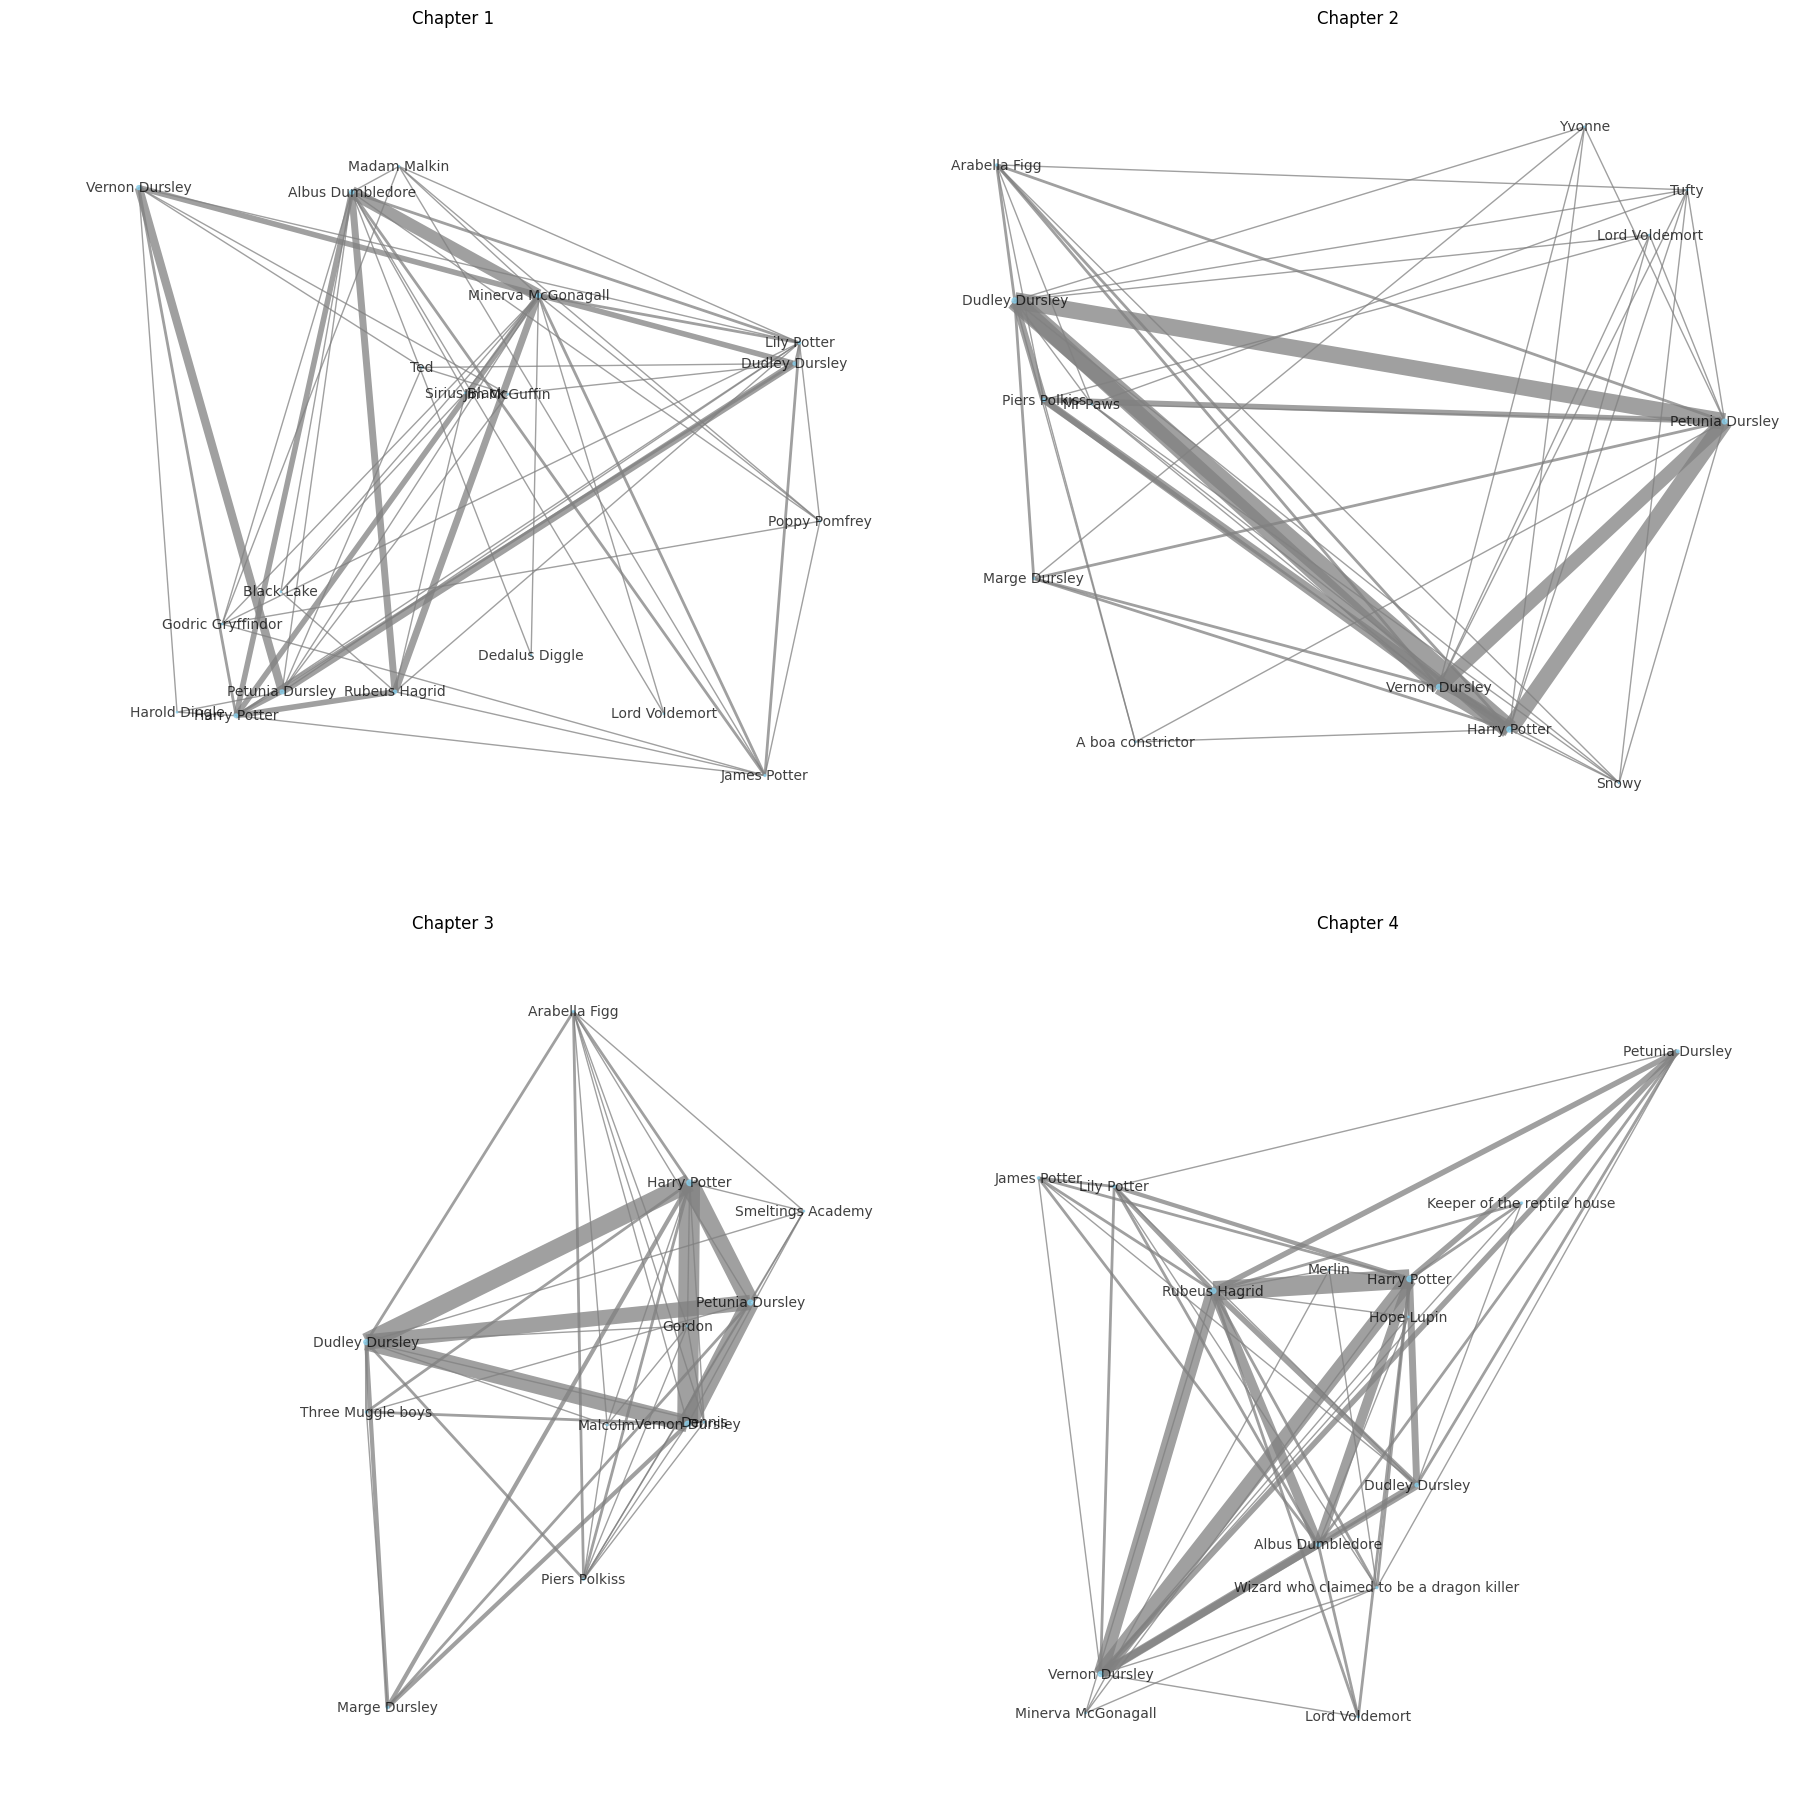

In [6]:
# draw network (random for starters)
# nw.visualize(G)
fig, axs = plt.subplots(2, 2, figsize=(18, 18), constrained_layout=True)

for chapternr in range(1,5):
    # Get node sizes
    node_sizes = [node[1]['sizes'][chapternr] for node in G.nodes.data()]

    # Get edge widths
    width = [edge[2]['weight'][chapternr] for edge in G.edges.data()]

    # Get labels
    labels = {}
    for node in G.nodes.data():
        if node[1]['sizes'][chapternr] != 0:
            labels.update({node[0]: node[0]})

    # plot
    nx.draw_random(G, node_size = node_sizes, width=width, edge_color = 'grey', node_color = 'skyblue', alpha = 0.75,
                   labels = labels, with_labels=True,
                   font_size=10, ax = axs[(chapternr-1)//2, (chapternr-1)%2])
    axs[(chapternr-1)//2, (chapternr-1)%2].set_title(f"Chapter {chapternr}")
plt.show()

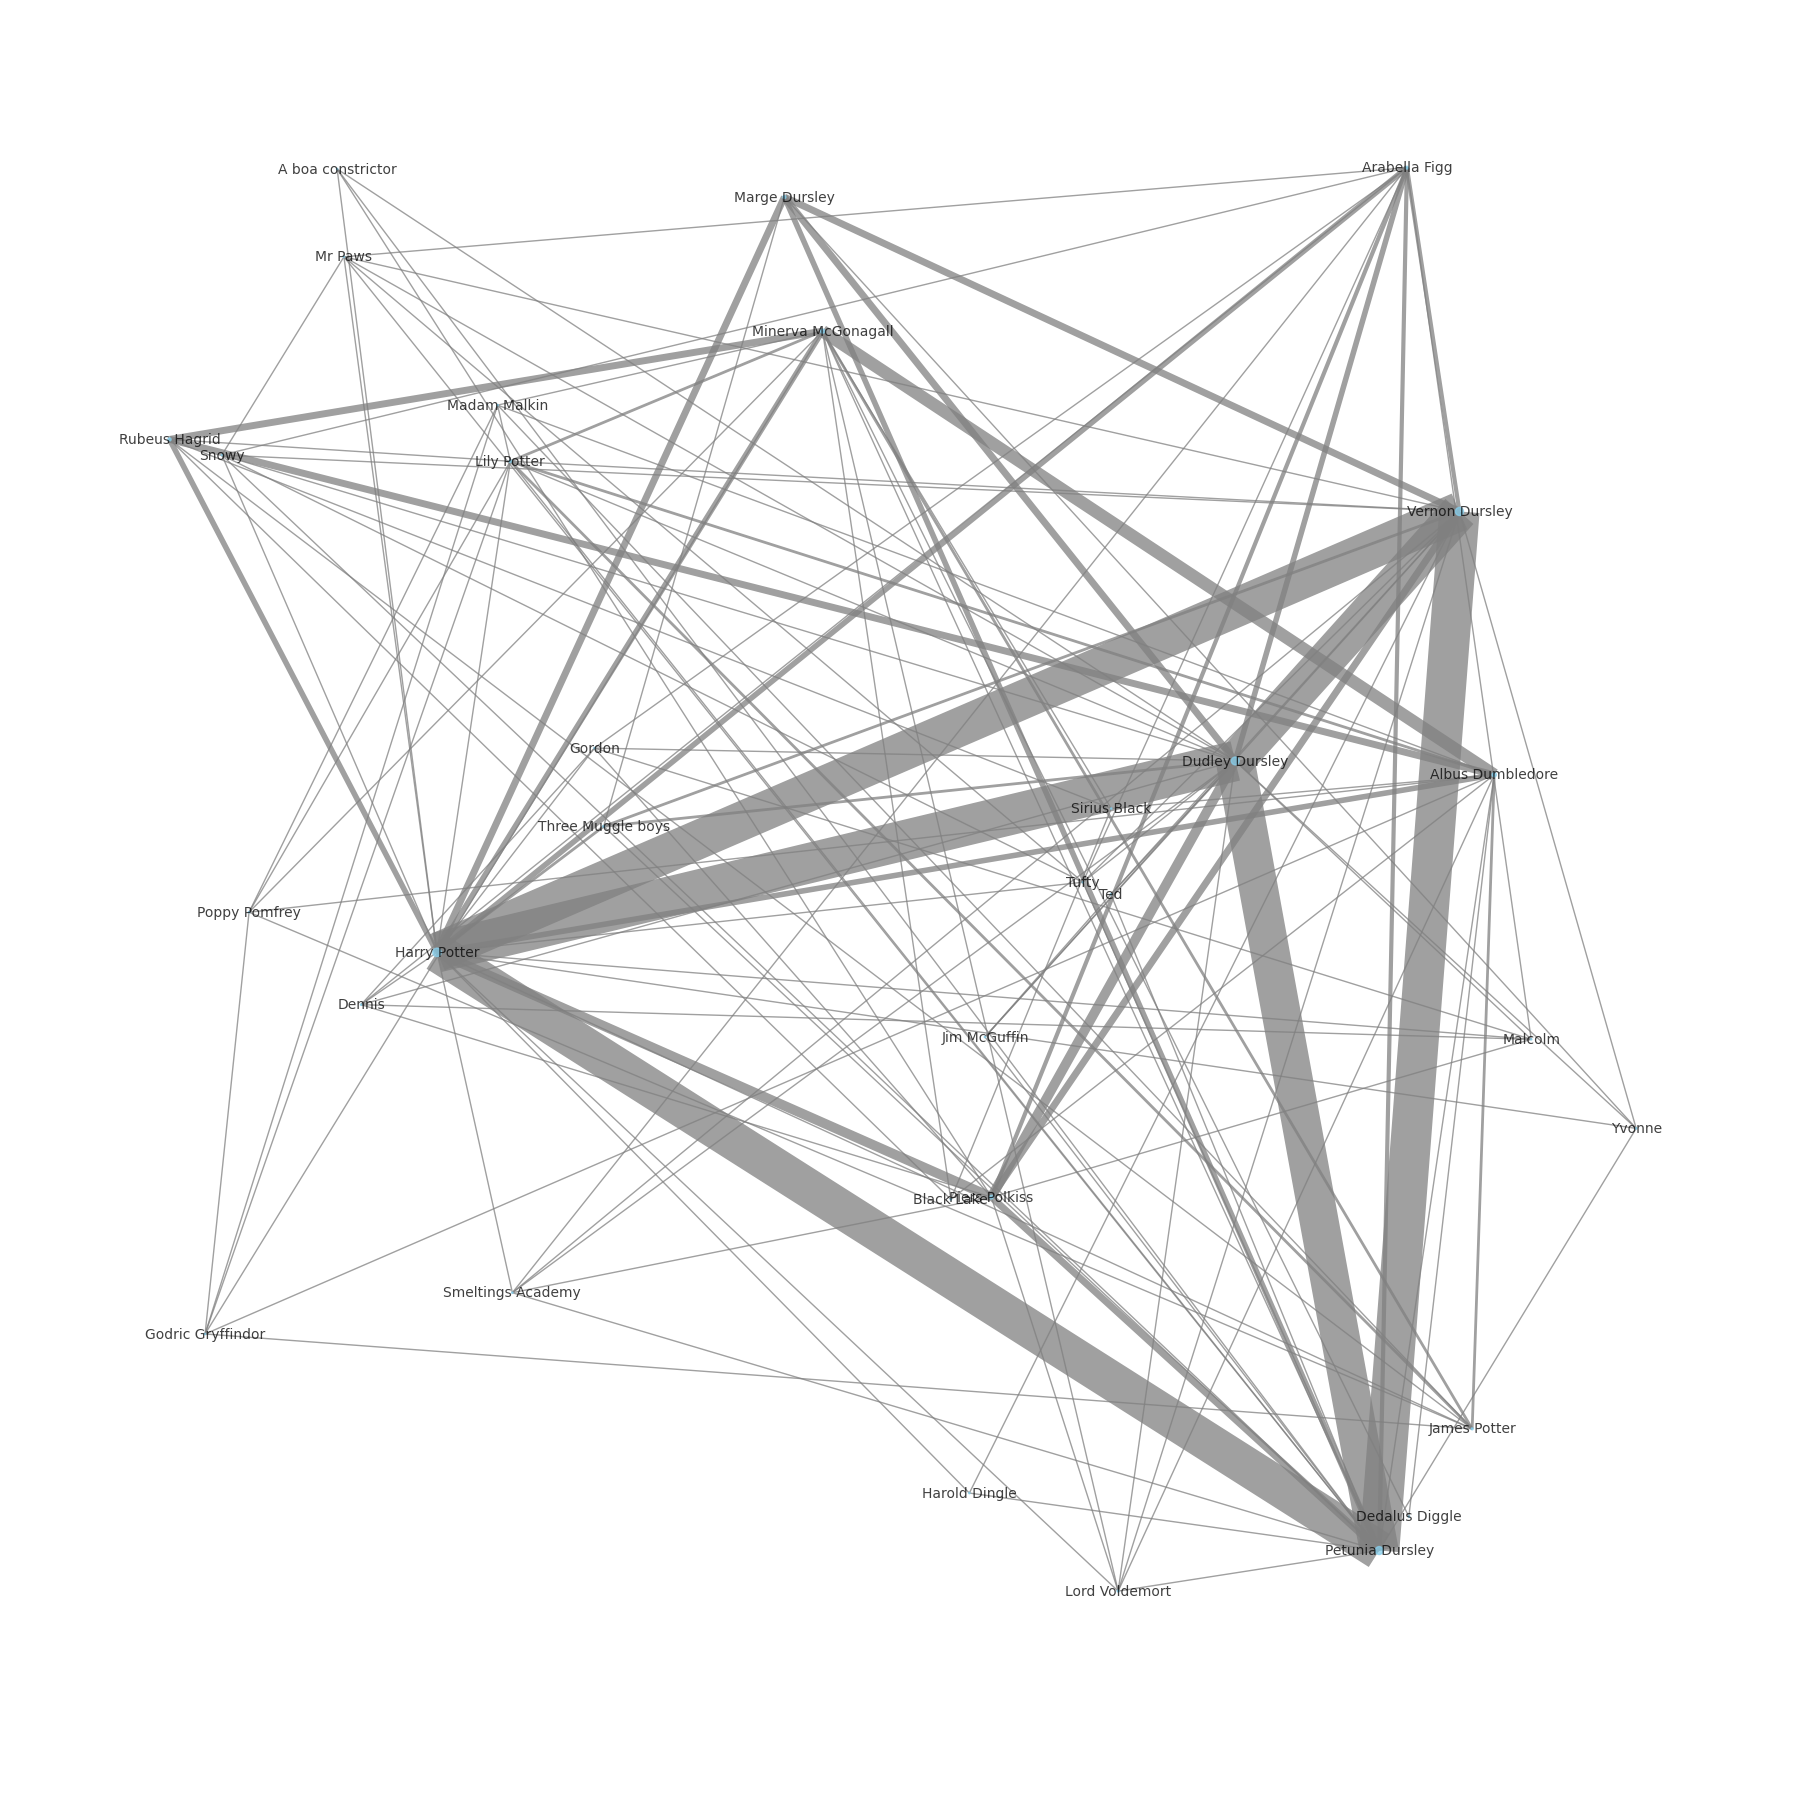

In [7]:
chapternr = [1, 2, 3]

# draw network
fig, axs = plt.subplots(1, figsize=(18, 18), constrained_layout=True)

node_sizes = [[node[1]['sizes'][nr] for node in G.nodes.data()] for nr in chapternr]
node_sizes = [sum(s) for s in zip(*node_sizes)]

edge_weights = [[edge[2]['weight'][nr] for edge in G.edges.data()] for nr in chapternr]
edge_weights = [sum(w) for w in zip(*edge_weights)]

labels = {}
for i, node in enumerate(G.nodes):
    if node_sizes[i] != 0:
        labels.update({node: node})

# plot
nx.draw_random(G, node_size = node_sizes, width=edge_weights, edge_color = 'grey', node_color = 'skyblue', alpha = 0.75,
                labels = labels, with_labels=True,
                font_size=10, ax = axs)
plt.show()

In [8]:
# Save graph
pkl.dump(G, open('2.Network/Graphs/First_graph.pkl', 'wb'))

## TO DOs:
1. Fix the character lists with regards to the scraper, so we don't have dublicates
2. Check the above network code and see (1) if you can make it more efficient and (2) if you can make it more readable
3. Try to see if it makes more sense to get the networks based on: https://github.com/AlexDuvalinho/Dynamic-Graph-Networks
    3.1. As far as I can see, this is a more recent approach to the problem, so it might be worth a try
    3.2. The code seems to be very simple to get to work for our problem as we just need to clone the repo, put the books into the raw_text folder and run the code
    3.3. Huge plus is that the BERT_NER model has been fully trained and the weights can be downloaded from right here: https://onedrive.live.com/?authkey=%21AG6vMTjttNHJR5E&id=390AF7A51B5537E7%21776&cid=390AF7A51B5537E7&parId=root&parQt=sharedby&o=OneUp